In [130]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
%pylab inline
from scipy.stats import ttest_ind, ttest_ind_from_stats, ks_2samp
from scipy.special import stdtr
import seaborn as sns
sns.set_style("whitegrid")

np.random.seed(2017)

Populating the interactive namespace from numpy and matplotlib


In [2]:
delay = pd.read_csv('delay_95.csv')

In [6]:
taxi = pd.read_csv('finaldf.csv', index_col=0)

In [10]:
taxi['keycol'] = taxi.apply(lambda x: str(x.Station)+'_'+str(x.Date)+'_'+str(x.Hour), axis=1)

In [12]:
taxi = taxi.drop(['Station','Date','Hour'], axis=1)

In [13]:
taxi.head()

,Taxi_Rides,keycol
0,24,146_12_10
1,5,346_12_10
2,2,394_12_10
3,1,135_12_10
4,2,237_12_10


In [14]:
merged = pd.merge(delay, taxi, how='left', on='keycol')

In [17]:
merged.head()

,keycol,delay,Taxi_Rides
0,0_1_7,0,NaN
1,1_1_7,1,22.0
2,10_1_7,1,1.0
3,101_1_7,0,NaN
4,103_1_7,1,6.0


In [19]:
merged = merged.dropna()

In [49]:
merged['station'] = merged['keycol'].apply(lambda x: x.split('_')[0])
merged['hour'] = merged['keycol'].apply(lambda x: int(x.split('_')[2]))
merged.head()

,keycol,delay,Taxi_Rides,station,hour
1,1_1_7,1,22.0,1,7
2,10_1_7,1,1.0,10,7
4,103_1_7,1,6.0,103,7
5,104_1_7,2,1.0,104,7
10,11_1_7,3,4.0,11,7


In [50]:
the_delays = merged[merged.delay>0]
the_control = merged[merged.delay==0]
print "number of delays: " + str(len(the_delays))
print "number of good service (kind of): " + str(len(the_control))


number of delays: 6299
number of good service (kind of): 6750


In [51]:
print "mean taxi rides on delays: " + str(the_delays.Taxi_Rides.mean())
print "mean taxi rides on good services: " + str(the_control.Taxi_Rides.mean())

mean taxi rides on delays: 10.0527067789
mean taxi rides on good services: 9.65925925926


In [52]:
t, p = ttest_ind(the_delays.Taxi_Rides, the_control.Taxi_Rides, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

ttest_ind:            t = 1.66078  p = 0.096782


# by hour

In [145]:
by_hour = pd.DataFrame({'delay': the_delays.groupby('hour').mean()['Taxi_Rides'],
                        'control': the_control.groupby('hour').mean()['Taxi_Rides']})

In [146]:
by_hour.T

hour,7,8,9,10,11,12,13,14,15,16,17,18,19,20
control,7.056218,8.697974,7.909091,8.648472,10.063107,10.157773,10.612335,11.233918,9.301344,9.244860,9.924731,11.703364,10.731752,11.926829
delay,7.618799,9.091723,10.519149,9.061785,9.751678,9.565310,9.176334,9.034398,10.914835,9.732258,11.627907,10.897833,12.224359,10.736264


In [147]:
# let's test the p-value by hour
ks_p_values = []
ttest_p_values = []
for i in range(7,21):
    delay_per_hour = the_delays[the_delays.hour == i]['Taxi_Rides']
    control_per_hour = the_control[the_control.hour == i]['Taxi_Rides']
    t, pt = ttest_ind(control_per_hour,delay_per_hour, equal_var=False)
    k,pk = ks_2samp(control_per_hour, delay_per_hour)
    ks_p_values.append(pk)
    ttest_p_values.append(pt)

In [149]:
by_hour['ks p-values'] = ks_p_values
by_hour['t-test p-values'] = ttest_p_values
by_hour['significant'] = by_hour['t-test p-values'].apply(lambda x: 1 if x<0.05 else 0)
by_hour

,control,delay,ks p-values,t-test p-values,significant
hour,,,,,
7,7.056218,7.618799,0.999255,0.433841,0
8,8.697974,9.091723,0.880697,0.641205,0
9,7.909091,10.519149,0.154038,0.001714,1
10,8.648472,9.061785,0.525112,0.581653,0
11,10.063107,9.751678,0.619448,0.713688,0
12,10.157773,9.565310,0.002091,0.478589,0
13,10.612335,9.176334,0.006699,0.069734,0
14,11.233918,9.034398,0.002704,0.011743,1
15,9.301344,10.914835,0.277608,0.104414,0


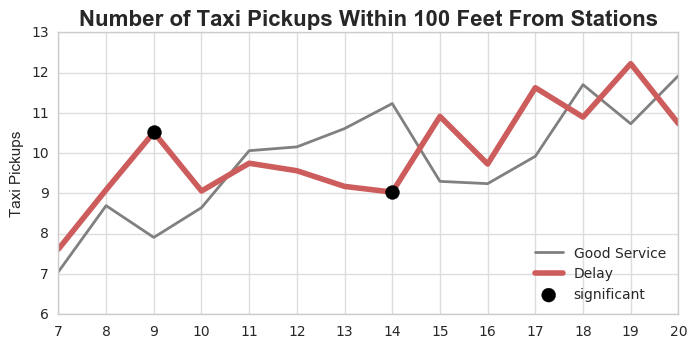

In [163]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(211)
plt.xticks(by_hour.index)
ax.scatter(by_hour[by_hour.significant==1].index,
           by_hour[by_hour.significant==1].delay,
          c="black",s=100, zorder=10, label='significant')
by_hour.control.plot(ax=ax, label="Good Service", c='gray', linewidth=2)
by_hour.delay.plot(ax=ax, label="Delay", c='IndianRed', linewidth=4)
ax.set_ylabel("Taxi Pickups")
ax.set_xlabel("")
plt.legend(loc='lower right')
ax.grid(color='#dddddd')
ax.set_title("Number of Taxi Pickups Within 100 Feet From Stations", fontweight='bold', fontsize=16)

# ax = fig.add_subplot(212)
# ax.set_xticks(by_hour.index)
# by_hour.p_values.plot(ax=ax, c='gray', linewidth=2)
# ax.set_title("p-values",fontweight="bold")
# ax.grid(color='#dddddd')



# by station

In [181]:
by_station = pd.DataFrame({'delay': the_delays.groupby('station').mean()['Taxi_Rides'],
                        'control': the_control.groupby('station').mean()['Taxi_Rides']})
by_station.dropna(inplace=True)

In [182]:
# let's test the p-value by station
ks_p_values = []
ttest_p_values = []
for i in by_station.index:
    delay_per_station = the_delays[the_delays.station == i]['Taxi_Rides']
    control_per_station = the_control[the_control.station == i]['Taxi_Rides']
    t, pt = ttest_ind(control_per_station,delay_per_station, equal_var=False)
    k,pk = ks_2samp(control_per_station, delay_per_station)
    ks_p_values.append(pk)
    ttest_p_values.append(pt)

In [183]:
by_station['ks p-values'] = ks_p_values
by_station['t-test p-values'] = ttest_p_values
by_station['significant'] = by_station['t-test p-values'].apply(lambda x: 1 if x<0.05 else 0)
by_station.head()

,control,delay,ks p-values,t-test p-values,significant
1,28.000000,26.229268,0.089602,0.085356,0
10,1.203704,1.500000,0.059648,0.008174,1
101,1.507463,1.891304,0.043858,0.038720,1
103,4.906433,5.137441,0.855797,0.475192,0
104,1.000000,1.000000,1.000000,NaN,0


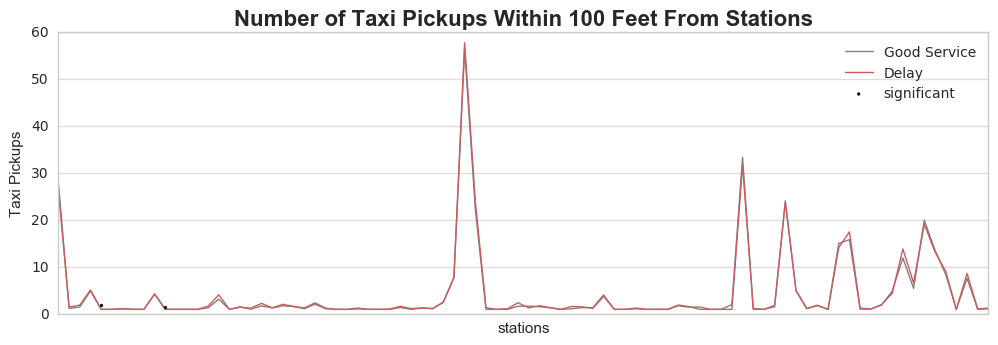

In [198]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
plt.xticks(by_station.index)
ax.scatter(by_station[by_station.significant==1].index,
           by_station[by_station.significant==1].delay,
          c="black",s=4, zorder=20, label='significant')
by_station.control.plot(ax=ax, label="Good Service", c='gray', linewidth=1)
by_station.delay.plot(ax=ax, label="Delay", c='IndianRed', linewidth=1)
ax.set_ylabel("Taxi Pickups")
ax.set_xlabel("stations")
ax.set_ylim([0,60])
plt.legend(loc='upper right')
ax.grid(color='#dddddd')
ax.set_title("Number of Taxi Pickups Within 100 Feet From Stations", fontweight='bold', fontsize=16)

# ax = fig.add_subplot(212)
# ax.set_xticks(by_hour.index)
# by_hour.p_values.plot(ax=ax, c='gray', linewidth=2)
# ax.set_title("p-values",fontweight="bold")
# ax.grid(color='#dddddd')



In [221]:
significant_stations = by_station[by_station.significant==1].copy().reset_index()
significant_stations.rename(columns={'index':'objectid'}, inplace=True)
significant_stations['objectid'] = significant_stations['objectid'].apply(int)
significant_stations

,objectid,control,delay,ks p-values,t-test p-values,significant
0,10,1.203704,1.500000,0.059648,0.008174,1
1,101,1.507463,1.891304,0.043858,0.038720,1
2,115,1.320755,1.676471,0.046277,0.001361,1
3,116,3.155689,4.078652,0.056562,0.003428,1
4,119,1.030303,1.255814,0.544968,0.019678,1
5,120,1.735294,2.269663,0.249709,0.007448,1
6,138,1.000000,1.151515,0.999998,0.006563,1
7,230,1.694444,1.304348,0.788295,0.022454,1
8,4,1.561644,1.854430,0.534267,0.034381,1
9,410,15.833333,17.494297,0.113617,0.022829,1


In [199]:
subwayst = gpd.GeoDataFrame.from_file('subway routes/subwaystations.shp')

In [202]:
subway = subwayst[['name','objectid']]
subway.index = subway.objectid.apply(int)

In [222]:
pd.merge(significant_stations, subway, how='left', on='objectid')

,objectid,control,delay,ks p-values,t-test p-values,significant,name
0,10,1.203704,1.500000,0.059648,0.008174,1,36th St
1,101,1.507463,1.891304,0.043858,0.038720,1,Vernon Blvd - Jackson Ave
2,115,1.320755,1.676471,0.046277,0.001361,1,Grand Army Plaza
3,116,3.155689,4.078652,0.056562,0.003428,1,Atlantic Av - Barclay's Center
4,119,1.030303,1.255814,0.544968,0.019678,1,Clinton - Washington Aves
5,120,1.735294,2.269663,0.249709,0.007448,1,7th Ave
6,138,1.000000,1.151515,0.999998,0.006563,1,Greenpoint Ave
7,230,1.694444,1.304348,0.788295,0.022454,1,69th St
8,4,1.561644,1.854430,0.534267,0.034381,1,Bergen St
9,410,15.833333,17.494297,0.113617,0.022829,1,Canal St - Holland Tunnel


In [225]:
subwayst[subwayst.objectid==416]

,geometry,line,name,notes,objectid,url
415,POINT (-74.00698581780337 40.71327233111697),R-W,City Hall,"N-nights, R-all other times",416.0,http://web.mta.info/nyct/service/
